# AI Literature Analysis

Analysis of AI research topic trends over time, with [BERTopic](https://maartengr.github.io/BERTopic/index.html).

In [9]:
from os import path

import bertopic
import kaggle
import pandas as pd
from sklearn.feature_extraction import text as sklearn_text
from IPython import display
import ipywidgets as widgets

## Arxiv Dataset

The [Arxiv dataset](https://www.kaggle.com/datasets/Cornell-University/arxiv) was chosen as:

 - Arxiv is widely used within the AI research community, to publish preprints and postprints of papers.
 - The dataset is updated on a weekly basis, which is useful given that the field is both young and evolving rapidly.
 - A team of moderators [re-categorize papers](https://arxiv.org/help/moderation), resulting in robust categories that can be used to pick out just AI research.
 
 To begin we'll download the data and clean it a little:

In [2]:
# Download dataset
data_dir = "/tmp/arxiv"
kaggle.api.dataset_download_files(
    dataset='Cornell-University/arxiv',
    path=data_dir,
    quiet=False,
    unzip=True,
)

# Set as a Pandas Dataframe
data_path = path.join(data_dir, "arxiv-metadata-oai-snapshot.json")
metadata = pd.read_json(data_path, orient="columns", lines=True)

# Clean data
metadata["id"] = metadata["id"].str.split("/").str[-1] # Remove ID prefix
metadata['categories'] = metadata['categories'].str.split(' ') # Convert string separated categories to lists
metadata["update_date"] = pd.to_datetime(metadata["update_date"], format="%Y-%m-%d") # Use date type
metadata.set_index('id', inplace=True) # Set ID as index

# Output key facts
number_papers = len(metadata)
oldest_paper = metadata["update_date"].dt.year.min()
newest_paper = metadata["update_date"].dt.year.max()
"Dataset contains {:,} papers, from {}-{}.".format(number_papers, oldest_paper, newest_paper)

100%|████████████████████████████████████████| 1.07G/1.07G [00:16<00:00, 70.8MB/s]


'Dataset contains 2,117,092 papers, from 2007-2022.'

Next we'll select just the relevant categories from the broader [Arxiv taxonomy](https://arxiv.org/category_taxonomy).

<AxesSubplot:xlabel='update_date'>

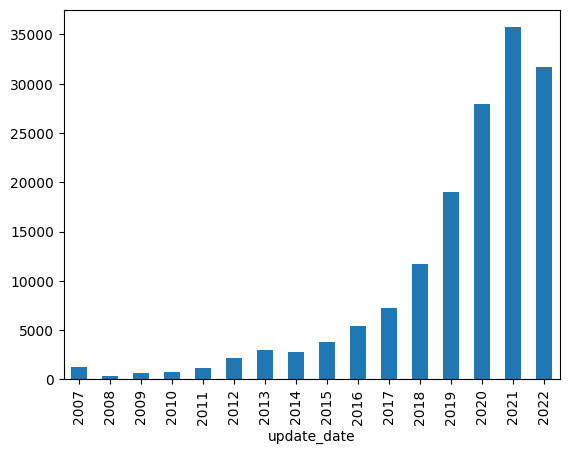

In [3]:
# List of AI categories
relevant_categories = [
    "cs.AI",  # Computer Science: Artificial Intelligence
    "cs.LG",  # Computer Science: Machine Learning
    "stat.ML",  # Statistics: Machine Learning
]

# Apply filter
def check_if_ai_paper(paper_categories: list[str]) -> bool:
    """Determine if the paper is in one of the AI categories"""
    return any(i in paper_categories for i in relevant_categories)

is_ai_paper = metadata["categories"].apply(check_if_ai_paper)
ai_papers = metadata[is_ai_paper]

# Show number of papers over time
ai_papers["update_date"].groupby(ai_papers["update_date"].dt.year).count().plot(kind="bar")

## BERTopic Analysis

> BERTopic is a topic modeling technique that leverages transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

[BERTopic](https://github.com/MaartenGr/BERTopic) is generally considered [state of the art](https://www.researchgate.net/publication/360410995_A_Topic_Modeling_Comparison_Between_LDA_NMF_Top2Vec_and_BERTopic_to_Demystify_Twitter_Posts) in topic modelling.

To begin, we'll add to the default stop words. This will help as there are various generic terms that are widely used amongst academic writing, which we don't want to use within the categories.

In [97]:
# Create the stop words list
stop_words = [
    *sklearn_text.ENGLISH_STOP_WORDS,
    "accuracy",
    "ai",
    "algorithm",
    "approach",
    "artificial",
    "based",
    "code",
    "data",
    "deep",
    "explain",
    "explains",
    "explanation",
    "inference",
    "intelligence",
    "item",
    "items",
    "learning",
    "machine",
    "method",
    "model",
    "model",
    "models",
    "models",
    "network",
    "networks",
    "neural",
    "optimization",
    "paper",
    "performance",
    "policies",
    "policy",
    "probability",
    "problem",
    "propose",
    "proposed",
    "research",
    "results",
    "set",
    "software",
    "theory",
    "training",
    "user",
    "using",
 ]
len(stop_words)

361

Now we can create the BERTopic model. 

We'll use the [all-mpnet-base-v2]((https://huggingface.co/sentence-transformers/all-mpnet-base-v2) sentence transform which maps paragraphs to a 768 dimensional dense vector space. This will give more accuracy than the default, at the expense of longer training time. It should take less than 30 minutes to train with a modern CUDA GPU, or 1-4 hours with CPU.

In [98]:
# Setup the topic model
topic_model = bertopic.BERTopic(
    verbose=True, 
    min_topic_size=500, # Increased given the relatively large dataset size
    embedding_model="all-mpnet-base-v2",
    vectorizer_model=sklearn_text.CountVectorizer(stop_words=stop_words) # Add our stop words
)

# Run
abstracts = ai_papers["abstract"].tolist() # BERTopic requires a list of strings
topics, _ = topic_model.fit_transform(abstracts)
display.clear_output()

We can see below that the categories are broadly as expected:

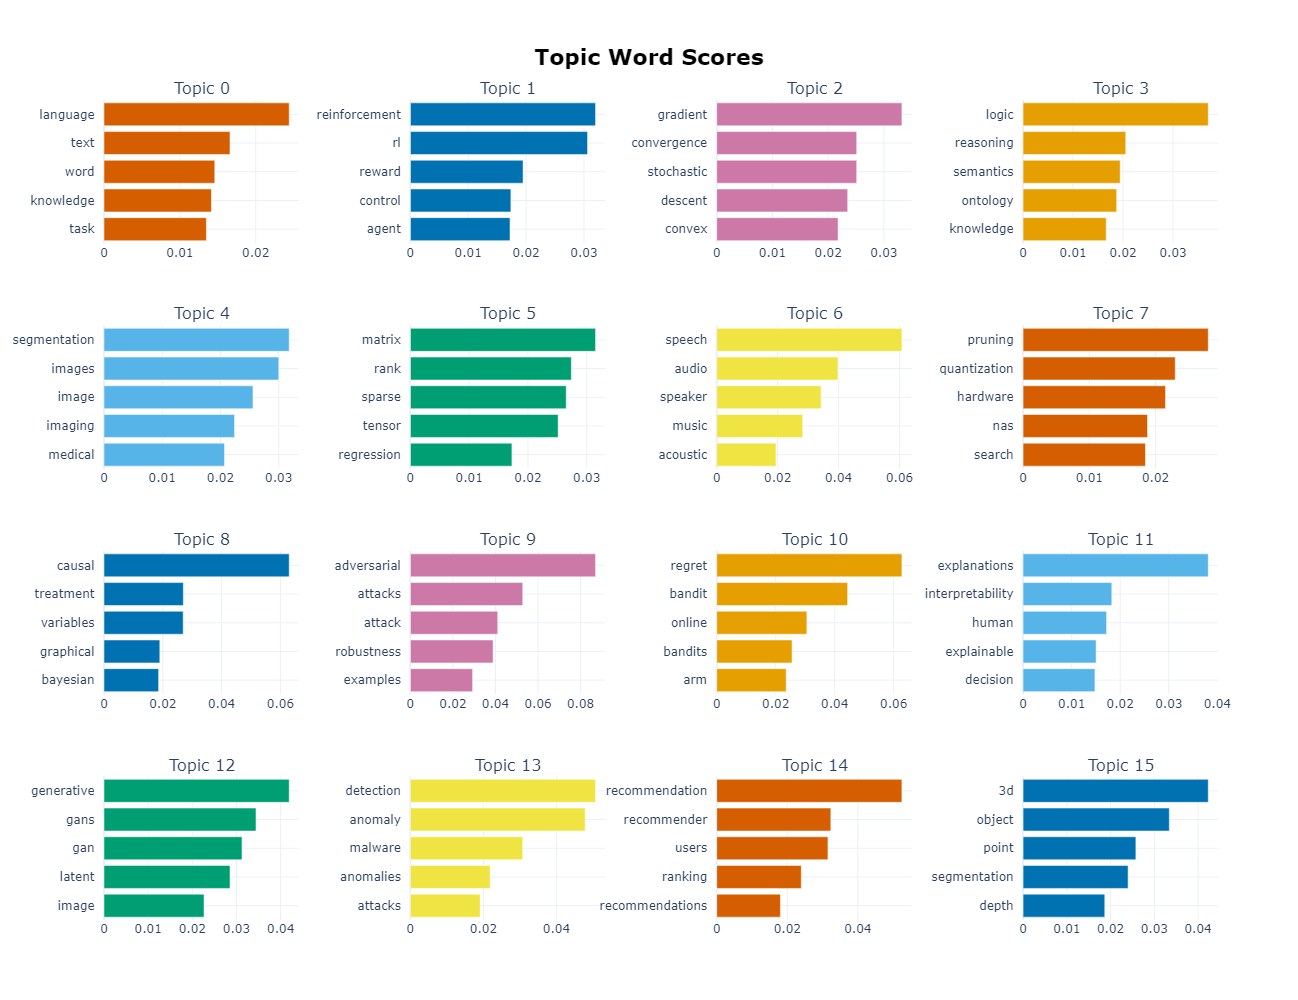

In [99]:
topic_model.visualize_barchart(top_n_topics=16)

We can also view the topic relationships in 2d using [Umap's](https://umap-learn.readthedocs.io/en/latest/) dimensionality reduction:

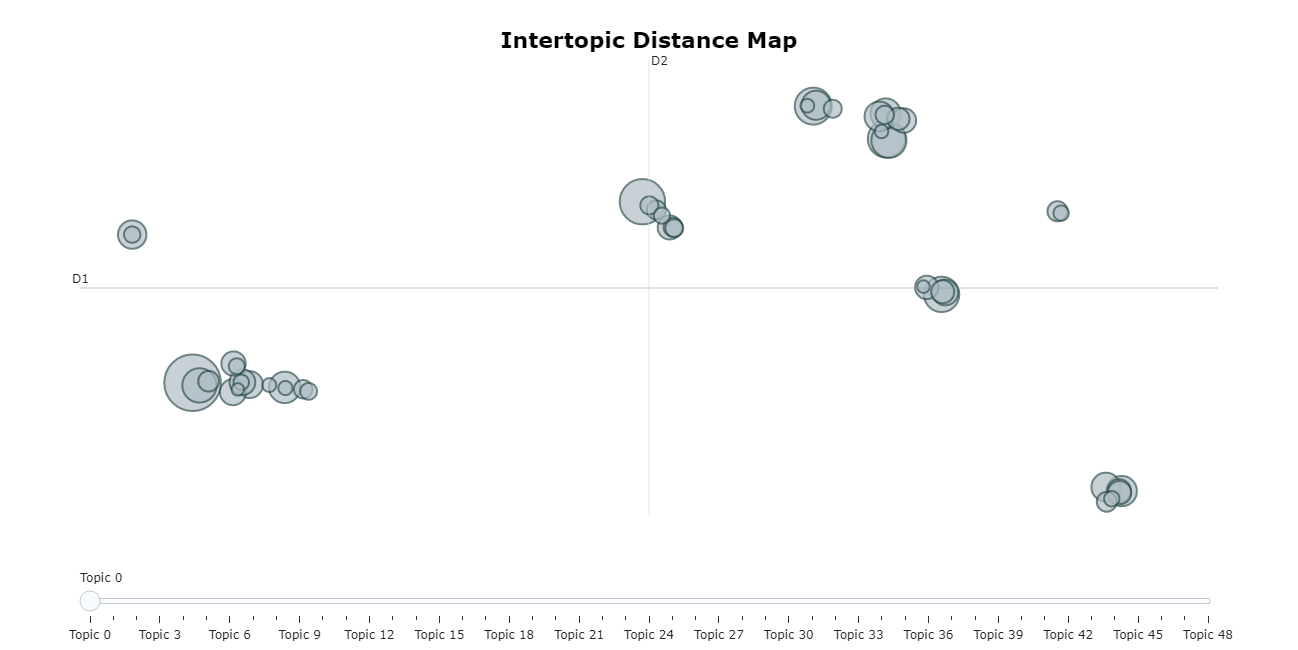

In [100]:
topic_model.visualize_topics()

### Topic Checks

In addition, we can look at some specific papers, to check they are being categorized in the way that we would expect.

In [121]:
# Create the topic dropdown
topic_df = topic_model.get_topic_info()
topic_options = topic_df[['Name', 'Topic']].apply(tuple, axis=1).to_list()
topic_options = topic_options[1:] # Remove -1 topic

topic_dropdown = widgets.Dropdown(
    options=topic_options,
    value=0,
    description='Topic:'
)
display.display(topic_dropdown)

# Show the abstract samples
out = widgets.Output()
display.display(out)

def on_change(change):
    with out:
        display.clear_output()
        
        # Show the new samples
        topic = change["old"]["index"]
        samples = topic_model.get_representative_docs(topic)
        
        keywords = [word for word, _p in topic_model.get_topic(topic)]
        
        for sample in samples:
            matched_keywords = [word for word in keywords if word in sample]
            print("Matched keywords:", matched_keywords)
            print (sample, "\n")

# Default to the first topic & display
on_change({"old": {"index": 0}})
topic_dropdown.observe(on_change)

Dropdown(description='Topic:', options=(('0_language_text_word_knowledge', 0), ('1_reinforcement_rl_reward_con…

Output()

## Trends over time

Finally we can show the trends of topics over time. Note that as the category as a whole is growing so fast, we'll show the relative frequency of topics in each year (i.e. the percent of all papers in that year).

In [102]:
# Generate the topics over time
years = ai_papers["update_date"].dt.year.tolist()
topics_over_time = topic_model.topics_over_time(abstracts, topics, years)

16it [00:36,  2.30s/it]


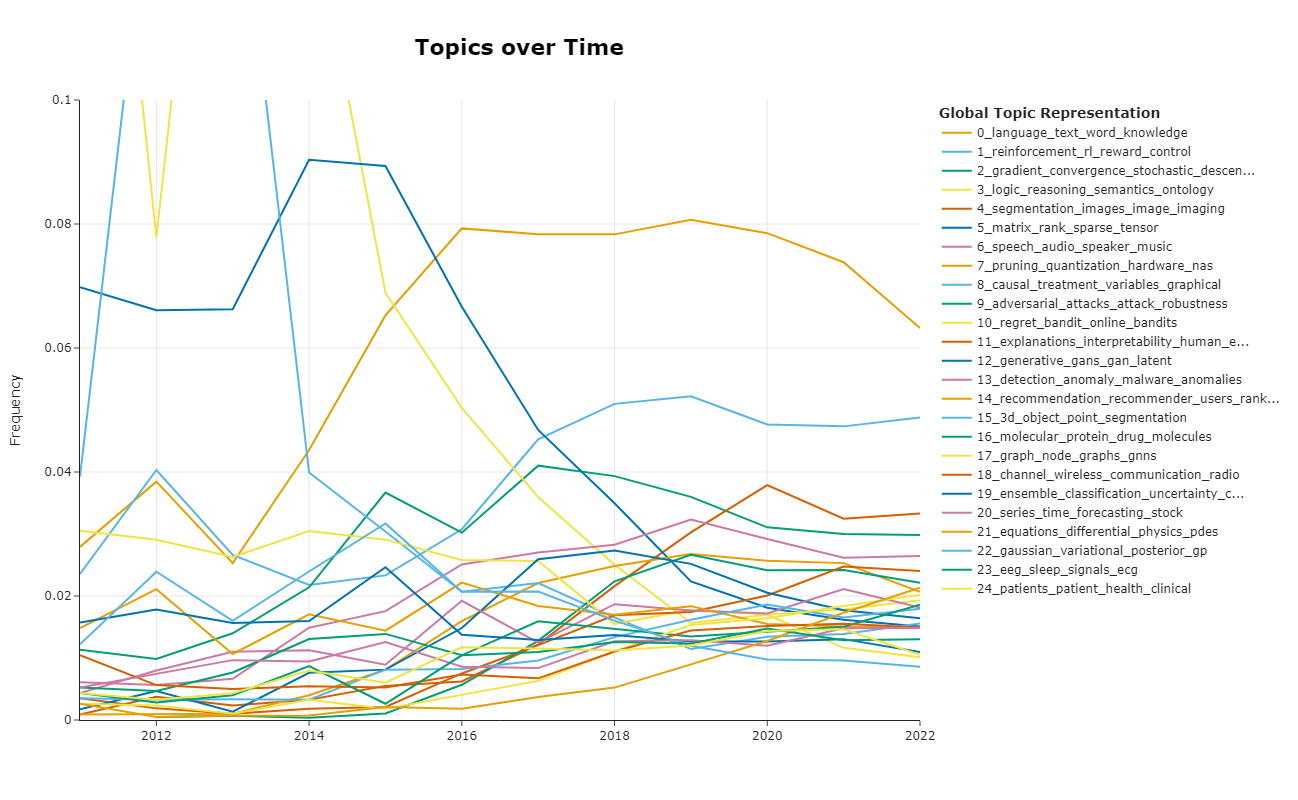

In [236]:
# Filter down the data
topics_filtered = topics_over_time[topics_over_time["Timestamp"] > 2010] # Remove the first few years of small data
topics_filtered = topics_filtered[topics_filtered["Topic"] > -1] # Remove BERTopic excluded keywords
topics_filtered = topics_filtered[topics_filtered["Topic"] < 25] # Remove small categories
topics_relative = topics_filtered.copy()

def get_percentage_of_year_total(row):
    # Get the total number of articles for this year
    timestamp = row["Timestamp"]
    year_rows = topics_over_time[topics_over_time['Timestamp'] == timestamp]
    year_total = year_rows["Frequency"].sum()
    
    # Return the relative frequency for the year
    return row["Frequency"] / year_total

topics_relative["Frequency"] = topics_relative.apply(get_percentage_of_year_total, axis=1)

plt = topic_model.visualize_topics_over_time(topics_relative, height=800)
plt.update_layout(yaxis_range=[0,0.1])
plt

We can also see the relative changes in a pivot table:

In [237]:
# Create the pivot table
pivot = topics_relative.pivot(index="Topic", columns="Timestamp", values="Frequency")
pivot = pivot.fillna(value=0)

# Add a change column
first_year = topics_relative["Timestamp"].min()
last_year = topics_relative["Timestamp"].max()
pivot["Change"] = pivot[last_year] - pivot[first_year]

# Add topic names
names = topic_model.get_topic_info()[["Topic", "Name"]]
pivot = pd.merge(pivot, names, on="Topic")
pivot = pivot.set_index("Name")
pivot = pivot.drop("Topic", axis=1)
pivot

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,Change
Name,,,,,,,,,,,,,
0_language_text_word_knowledge,0.027923,0.038444,0.025308,0.043541,0.065252,0.079290,0.078348,0.078327,0.080688,0.078518,0.073838,0.063219,0.035296
1_reinforcement_rl_reward_control,0.023560,0.040319,0.026640,0.021771,0.023323,0.030764,0.045280,0.050990,0.052201,0.047655,0.047359,0.048785,0.025225
2_gradient_convergence_stochastic_descent,0.011344,0.009845,0.013986,0.021408,0.036688,0.030214,0.041026,0.039335,0.035990,0.031078,0.030005,0.029845,0.018501
3_logic_reasoning_semantics_ontology,0.196335,0.077825,0.189477,0.133527,0.068920,0.050357,0.035950,0.025024,0.015634,0.016971,0.011644,0.010116,-0.186219
4_segmentation_images_image_imaging,0.000873,0.003751,0.002331,0.003266,0.005503,0.006226,0.012212,0.021596,0.030271,0.037880,0.032468,0.033311,0.032439
5_matrix_rank_sparse_tensor,0.069808,0.066104,0.066267,0.090348,0.089361,0.066654,0.046789,0.034964,0.022349,0.018117,0.016178,0.015064,-0.054744
6_speech_audio_speaker_music,0.006108,0.005626,0.006660,0.014877,0.017558,0.025087,0.027031,0.028280,0.032317,0.029180,0.026171,0.026441,0.020333
7_pruning_quantization_hardware_nas,0.000873,0.000938,0.000999,0.003991,0.008124,0.015931,0.022091,0.024852,0.026756,0.025671,0.025303,0.020674,0.019801
8_causal_treatment_variables_graphical,0.039267,0.145335,0.146187,0.039913,0.030398,0.020692,0.022091,0.016540,0.011437,0.013426,0.013883,0.015568,-0.023699
